# FYS375 Modellering av solfanger
Gruppe 3 - Høst 2021

Likevektskrav:  
Innstrålt $\pm$ 32  
Ta $\pm$ 1.5  
Tintlet $\pm$ 1  
massestrøm = mean $\pm$ 1std

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
data = pd.read_csv("Måledata_mars_juli_2020.csv")
data.Time = pd.to_datetime(data.Time)
data

,Time,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
0,2020-03-01 00:01:00,0.0,0.4,15.6,107.0,23.6
1,2020-03-01 00:02:00,0.0,0.4,15.6,107.0,23.6
2,2020-03-01 00:03:00,0.0,0.4,15.6,107.0,23.6
3,2020-03-01 00:04:00,0.0,0.4,15.6,107.0,23.6
4,2020-03-01 00:05:00,0.0,0.4,15.6,107.0,23.6
...,...,...,...,...,...,...
220314,2020-07-31 23:55:00,-1.0,17.7,25.5,0.0,26.9
220315,2020-07-31 23:56:00,-1.0,17.8,25.5,0.0,26.9
220316,2020-07-31 23:57:00,-1.0,17.8,25.5,0.0,26.9
220317,2020-07-31 23:58:00,-1.0,17.8,25.5,0.0,26.9


In [45]:
def find_irradiance(data):
    try:
        data_irra = data[data["Irradiance (W/m2)"] > 790]
    except:
        data_irra = data[data["Irradience (W/m2)"] > 790]
    return data_irra.to_numpy()

In [8]:
def find_15_min_intervall(np_data):
    info = []
    for i, (tid, irradiance, Ta, Ti, ms, To) in enumerate(np_data[15:]):
        if tid - np_data[i][0] == pd.Timedelta("15m"):
            # save all 15 minutes innside infomration
            info.append(np_data[i:i+15])
    info = np.array(info)
    return info

## Sette opp kravene våres til steady-state

In [17]:
def steady_state_krav(info):
    innenfor_krav = []

    for intervall15min in info:
        ir_mean, Ta_mean, Ti_mean, _, To_mean = (np.mean(intervall15min[:,1:], axis=0))
        if (np.max(abs(ir_mean - intervall15min[:,1])) <= 32 and 
            np.max(abs(Ta_mean - intervall15min[:,2])) <= 1.5 and 
            np.max(abs(To_mean - intervall15min[:,5])) <= 1 and
            np.min(intervall15min[:,4]) >= 50):

            innenfor_krav.append(intervall15min)
    innenfor_krav = np.array(innenfor_krav)
    return innenfor_krav

In [22]:
def delete_duplicates(innenfor_krav):
    femtenmin_split = np.array(innenfor_krav[0:2])

    for i,v in enumerate(innenfor_krav[2:]):
        print(f"{i} av {len(innenfor_krav[2:])}",end="\r")
        if not np.isin(v[:,0], femtenmin_split[:, :, 0]).any():
            #print("legger til")
            femtenmin_split = np.append(femtenmin_split, [v], axis=0)

    femtenmin_split = femtenmin_split[1:]
    return femtenmin_split

## Fjerne rare massestrømmer: mean $\pm$ 1std

In [20]:
def remove_ms_std(femtenmin_split):
    snitt = np.mean(femtenmin_split[:, :, 4].flatten())
    std = np.std(femtenmin_split[:, :, 4].flatten())

    femtenmin_split = femtenmin_split[(abs(femtenmin_split[:,:,4] - snitt) /std <= 1).any(axis=1)]
    print(f"snitt: {snitt:.2f}, std:{std:.2f}")
    return femtenmin_split

In [23]:
data_irra = find_irradiance(data)
info = find_15_min_intervall(data_irra)
innenfor_krav = steady_state_krav(info)
femtenmi_split = delete_duplicates(innenfor_krav)
femtenmi_split = remove_ms_std(femtenmi_split)

snitt: 374.29, std:42.89


In [16]:
femtenmin_split.shape

(652, 15, 6)

In [14]:
pd.DataFrame(femtenmin_split[251])

,0,1,2,3,4,5
0,2020-05-27 15:19:00,855.0,17.7,20.1,335.0,41.95
1,2020-05-27 15:20:00,853.0,18.0,20.1,335.0,41.95
2,2020-05-27 15:21:00,850.0,18.1,20.1,334.0,42.05
3,2020-05-27 15:22:00,848.0,18.2,20.2,334.0,42.25
4,2020-05-27 15:23:00,846.0,18.2,20.1,332.0,42.25
5,2020-05-27 15:24:00,844.0,17.8,20.1,331.0,42.30
6,2020-05-27 15:25:00,841.0,17.6,20.2,330.0,42.30
7,2020-05-27 15:26:00,839.0,18.0,20.2,330.0,42.30
8,2020-05-27 15:27:00,837.0,18.2,20.2,330.0,42.30
9,2020-05-27 15:28:00,835.0,18.2,20.2,328.0,42.30


# Modellering

### Finne variabel (X) veridene for hvert momentanpunkt:   
(1) $\frac{T_i - T_a}{G_T}$  Tm2/W  

### Finne virkningsgrad ved å se max effekt og Q  
(2) $\eta = \frac{Q}{E_{max}}$


### Virkinggrad er da Q / max effekt  
Q er hvor mye effekt som har gått ned i å varme opp vannet. $Q = m * c * \Delta T$   [g/s * j/(kg * K) * K] =
[g/s * j/kg] = [g/s * j/g] = [j/s] = [W]

c = 4.183 j/g K  
(3) $Q = \dot{m} * c * \Delta T $ [W]

### Max effekt
Solfanger er 67,2 m2  
(4) $GA = G * A $  
Der A = 67.2 m2 og G = G

### Varmetapskoef
$U_{L} = \frac{Q}{A \Delta T}$ [W/m2*K]

In [40]:
def formulas(femtenmin_split):
    X = []
    Q = []
    GA = []
    for i in femtenmin_split:
        ir_mean, Ta_mean, Ti_mean, m_s_mean, To_mean = np.mean(i[:, 1:], axis=0)

        # X formelen
        x = (Ti_mean - Ta_mean)/ir_mean 
        X.append(x)

        # Q formelen
        q = m_s_mean * 4.183 * (To_mean - Ti_mean)
        Q.append(q)

        # GA foremlen
        ga = ir_mean * 67.2
        GA.append(ga)


    X = np.array(X)
    Q = np.array(Q)
    GA = np.array(GA)
    n = Q/GA
    return X, Q, GA, n

In [41]:
X, Q, GA, n = formulas(femtenmi_split)

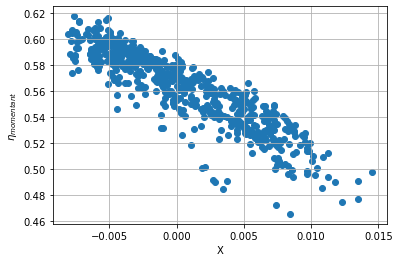

In [42]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.grid()
plt.xlabel("X")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [30]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X[n>0.2].reshape(-1,1),n[n>0.2].reshape(-1,1))
reg.score(X[n>0.2].reshape(-1,1),n[n>0.2].reshape(-1,1))

0.7883133870578287

In [31]:
X.reshape(-1,1).shape

(652, 1)

In [32]:
pred = reg.predict(X[n>0.2].reshape(-1,1))

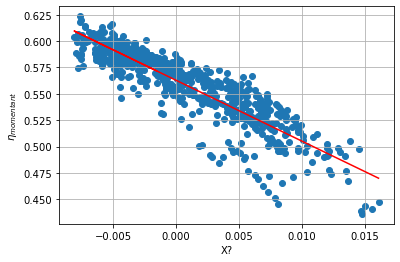

In [33]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.plot(X[n>0.2],pred, c="red", label="model")
plt.grid()
plt.xlabel("X?")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [34]:
print(f"b1: {reg.coef_}.. = Fr*Ul")

b1: [[-5.76420619]].. = Fr*Ul


In [35]:
print(f"b0: {reg.intercept_}.. = FR(τα)")

b0: [0.56297855].. = FR(τα)


In [38]:
Fr = reg.intercept_ / (0.85 * 0.95) 
print(f"F_r er {Fr}")

F_r er [0.69718706]


In [39]:
Ul  = reg.coef_[0][0] / Fr
print(f"Ul er {Ul}")

Ul er [-8.26780434]


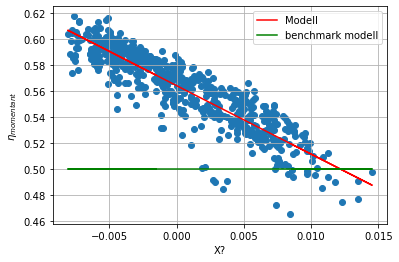

In [24]:
dårlig_prediksjon = [0.5 for i in range(584)]
plt.scatter(X[n>0.2],n[n>0.2])
plt.plot(X[n>0.2],pred, c="red", label="Modell")
plt.plot(X[n>0.2],dårlig_prediksjon, c="green", label="benchmark modell")
plt.grid()
plt.legend()
plt.xlabel("X?")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_percentage_error
print(f"Lav er bra \n\
Dårlig model: {mean_absolute_percentage_error(n[n>0.2], dårlig_prediksjon):.4f} \n\
God modell: {mean_absolute_percentage_error(n[n>0.2], pred):.4f}")

Lav er bra 
Dårlig model: 0.108 
God modell: 0.02


# Test modell på ukjent data
Last data fra 2021 og se hvordan modellen gjør det. Alt må gjøres på nytt

In [47]:
data2021 = pd.read_csv("Måledata_mars_juli_2021.csv")
data2021.Time = pd.to_datetime(data2021.Time)
data_irra = find_irradiance(data2021)
info = find_15_min_intervall(data_irra)
innenfor_krav = steady_state_krav(info)
femtenmi_split = delete_duplicates(innenfor_krav)
femtenmi_split = remove_ms_std(femtenmi_split)

snitt: 377.05, std:38.86


# Plot resultat
Forandre verdier hvis jeg gidder

In [48]:
X, Q, GA, n = formulas(femtenmi_split)

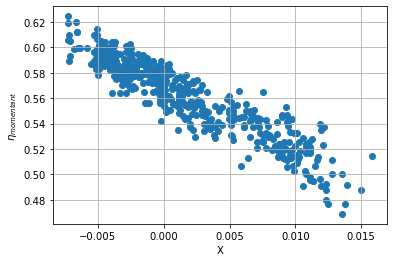

In [49]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.grid()
plt.xlabel("X")
plt.ylabel("$\eta_{momentant}$")
plt.show()

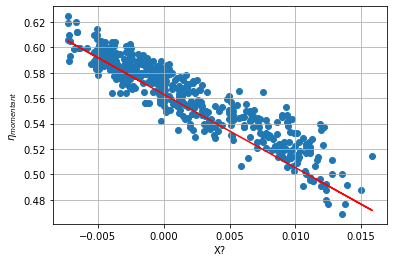

In [50]:
pred = reg.predict(X[n>0.2].reshape(-1,1))
plt.scatter(X[n>0.2],n[n>0.2])
plt.plot(X[n>0.2],pred, c="red", label="model")
plt.grid()
plt.xlabel("X?")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [51]:
print(mean_absolute_percentage_error(n[n>0.2], pred))

NameError: name 'mean_absolute_percentage_error' is not defined

In [52]:
r2_score(n[n>0.2], pred)

NameError: name 'r2_score' is not defined

## Estimere Q for 2021

In [123]:
data = pd.read_csv("Måledata_mars_juli_2021.csv")

In [124]:
data.Time = pd.to_datetime(data.Time)
data.index = data.Time
data = data.drop(columns=["Time"])
data

,Irradience (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
Time,,,,,
2021-03-03 11:56:00,111.0,0.4,22.2,0.0,26.70
2021-03-03 11:57:00,111.0,0.4,22.2,0.0,26.70
2021-03-03 11:58:00,108.0,0.4,22.2,0.0,26.65
2021-03-03 11:59:00,107.0,0.4,22.2,0.0,26.60
2021-03-03 12:00:00,103.0,0.4,22.2,0.0,26.60
...,...,...,...,...,...
2021-07-31 23:55:00,-1.0,15.9,26.0,0.0,26.75
2021-07-31 23:56:00,-1.0,15.9,26.0,0.0,26.75
2021-07-31 23:57:00,-1.0,15.9,26.0,0.0,26.75


In [125]:
data["energi [kWh]"] = data["Mass flow (g/s)"] * 4.183 * (data["Outlet Temperature (C)"] - data["Inlet Temperature (C)"]) * (1/60) *1e-3

$\eta = \frac{Q}{GA} = Fr * (\tau \alpha) - Fr * Ul \frac{T_i - T_a}{G} $  

$Q = Fr *  (\tau \alpha) * GA - Fr * Ul (T_i - T_a) * A $

$\eta = \frac{Q}{GA} = \frac{\dot{m} * c * \Delta T}{GA}$

In [132]:
Fr = 0.69718706
Ul = -8.26780434
tau = 0.85
alpha = 0.95
areal = 67.2
#data["pred eta"] = Fr * (tau * alpha) - Fr * Ul * (data["Inlet Temperature (C)"] -data["Ambient Temperature (C)"])/ data["Irradiance (W/m2)"]
#data["eta"] = (data["Mass flow (g/s)"] * 4.183 * (data["Outlet Temperature (C)"] - data["Inlet Temperature (C)"]))/( data["Irradiance (W/m2)"]*areal)

data["pred Q [W]"] = Fr * (tau * alpha) * data["Irradience (W/m2)"] * areal - Fr * Ul * (data["Inlet Temperature (C)"] -data["Ambient Temperature (C)"]) * areal
data["pred energi [kWh]"] = data["pred Q [W]"] * (1/60) * 1e-3
data["dårligmodell [kWh]"] = data['Irradience (W/m2)'] * areal * 0.5 * (1/60) * 1e-3

In [133]:
data_per_dag = data.resample("1D").sum()
data_per_dag[["energi [kWh]", "pred energi [kWh]"]]

,energi [kWh],pred energi [kWh]
Time,,
2021-03-03,0.000000,114.647936
2021-03-04,127.112732,332.783125
2021-03-05,131.633527,343.666286
2021-03-06,1.094667,173.596549
2021-03-07,114.626097,317.516674
...,...,...
2021-07-27,0.000000,110.086308
2021-07-28,93.590965,177.128897
2021-07-29,2.057747,141.504516


(0.0, 450.0)

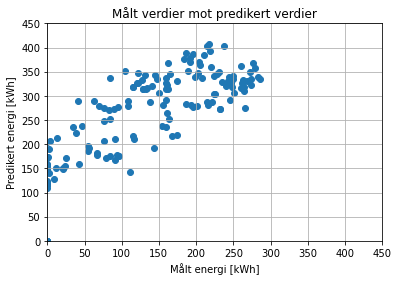

In [130]:
plt.scatter(data_per_dag["energi [kWh]"], data_per_dag["pred energi [kWh]"])
plt.xlabel("Målt energi [kWh]")
plt.ylabel("Predikert energi [kWh]")
plt.title("Målt verdier mot predikert verdier")
plt.grid()
plt.ylim(0,450)
plt.xlim(0,450)

(0.0, 450.0)

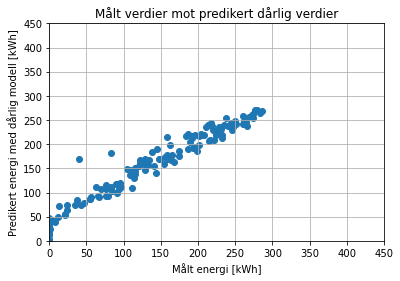

In [134]:
plt.scatter(data_per_dag["energi [kWh]"], data_per_dag["dårligmodell [kWh]"])
plt.xlabel("Målt energi [kWh]")
plt.ylabel("Predikert energi med dårlig modell [kWh]")
plt.title("Målt verdier mot predikert dårlig verdier")
plt.grid()
plt.ylim(0,450)
plt.xlim(0,450)

In [137]:
data_per_dag["energi [kWh]"].sum()/67.2

304.6758722677207